In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def logic_win(x,x_r):
    return (x >= x_r[0]) & (x < x_r[1])

In [4]:
path = '../Dataframes/combined_collisions_v3.csv'

df = pd.read_csv(path)
df.drop(columns='Unnamed: 0',inplace=True)

#### Clean up dataset

In [7]:
#Time column has some nans in it, must drop those entries

def is_str(x):
    Nx = len(x)
    I = np.ones(Nx).astype(bool)
    for ii in range(Nx):
        if type(x[ii]) != str:
            I[ii] = False
    return I

df = df.loc[is_str(df.Time.values),:]
df.aadf_Count_point_id = df.aadf_Count_point_id.values.astype(int)

<ipython-input-7-47a7e7548493>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.aadf_Count_point_id = df.aadf_Count_point_id.values.astype(int)


In [8]:
#make hour, year and month columns
    #hour will be rounded 
def get_hour(T):
    Nt = len(T)
    H = np.zeros(Nt).astype(int)
    for ii in range(Nt):
        s = T[ii].split(':')
        h = int(s[0])
        m = int(s[1])
        if m > 30:
            h += 1
        H[ii] = h % 24
    return H

def get_ymd(D):
    Nd = len(D)
    # |
    ymd = np.zeros((Nd,3)).astype(int)
    for ii in range(Nd):
        s = D[ii].split('-')
        for nn in range(3):
            ymd[ii,nn] = int(s[nn])
    return ymd

df[['y','m','d']] = get_ymd(df.Date.values)
df['h'] = get_hour(df.Time.values)

<ipython-input-8-5ae0e2d264d2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['y','m','d']] = get_ymd(df.Date.values)
<ipython-input-8-5ae0e2d264d2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['y','m','d']] = get_ymd(df.Date.values)
<ipython-input-8-5ae0e2d264d2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [13]:
print(np.sort(df.y.value_counts().index))
inds = np.argsort(df.y.value_counts().index)

[2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


In [14]:
print(df.y.value_counts().values[inds])

[16847 16440 16458 16583 17369 17604 19645 19489 19751 21624 16886 18741
 16071 17443]


In [5]:
#filter data out for a partciular geographic location. Here we choose Greater London

#central London box
Lat_r = [51.475,51.543]
Lon_r = [-0.179,0.023]

I_lat = (df.Latitude > Lat_r[0]) & (df.Latitude < Lat_r[1])
I_lon = (df.Longitude > Lon_r[0]) & (df.Longitude < Lon_r[1])
I = I_lat & I_lon

df_lond = df.loc[I,:].copy()

In [6]:
#drop all data that don't have traffic matches

I = df_lond.match == True
df_lond = df_lond.loc[I,:]

#### Make neighborhoods features

In [7]:
#Make a 3 (Lat, N/S) x 6 (Lon, E/W) grid
Nlat = 3
Nlon = 6
Nneigh = Nlon*Nlat

edges_lat = np.linspace(*Lat_r,Nlat+1)
dlat = np.diff(edges_lat)[0]
bins_lat = edges_lat[:-1]+0.5*dlat
edges_lon = np.linspace(*Lon_r,Nlon+1)
dlon = np.diff(edges_lon)[0]
bins_lon = edges_lon[:-1]+0.5*dlon

coord_neigh = [None]*Nneigh

df_lond['neigh'] = 0 #initialize neighborhood feature
ir = 0 #these are lat bins (rows)
ic = 0 #lon bins
for ii in range(Nneigh):
    Ilat = logic_win(df_lond.Latitude,(edges_lat[ir],edges_lat[ir+1]))
    Ilon = logic_win(df_lond.Longitude,(edges_lon[ic],edges_lon[ic+1]))
    I = Ilat & Ilon
    df_lond.loc[I,'neigh'] = ii
    
    coord_neigh[ii] = np.array([bins_lat[ir],bins_lon[ic]])
    
    ic+=1
    if ic == Nlon:
        ic = 0
        ir+=1

#### Look at traffic volume in neighborhoods

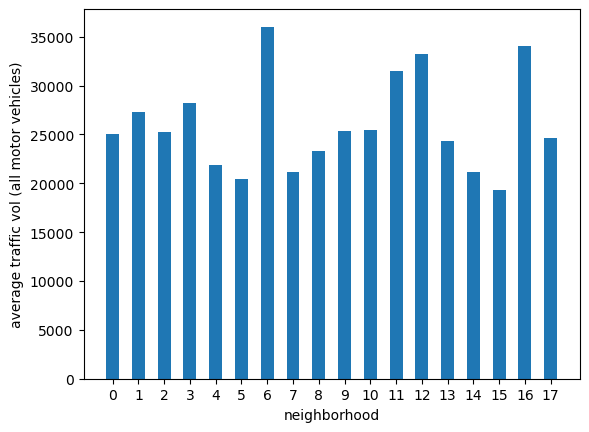

In [8]:
#get average traffic volume across all incidents for neighborhoods

feat = 'aadf_All_motor_vehicles'
#feat = 'aadf_Pedal_cycles'

TVol_neigh = np.zeros(Nneigh)
for ii in range(Nneigh):
    I = df_lond.neigh == ii
    TVol_neigh[ii] = df_lond.loc[I,feat].values.mean()
    
plt.bar(np.arange(Nneigh).astype(int),TVol_neigh,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('average traffic vol (all motor vehicles)')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

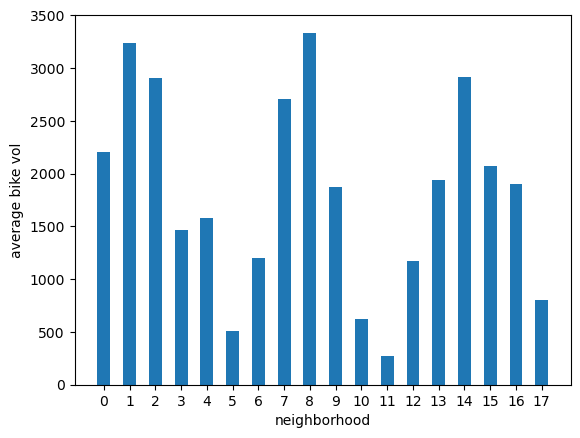

In [9]:
#get average bike volume across all incidents for neighborhoods

#feat = 'aadf_All_motor_vehicles'
feat = 'aadf_Pedal_cycles'

TVol_neigh = np.zeros(Nneigh)
for ii in range(Nneigh):
    I = df_lond.neigh == ii
    TVol_neigh[ii] = df_lond.loc[I,feat].values.mean()
    
plt.bar(np.arange(Nneigh).astype(int),TVol_neigh,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('average bike vol')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

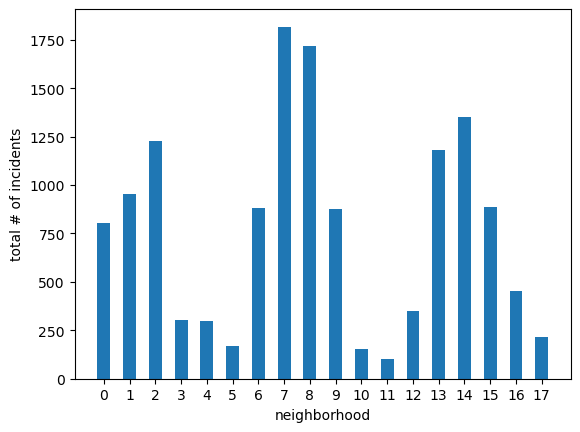

In [10]:
#get total # of incidents in neighborhoods 

#feat = 'aadf_All_motor_vehicles'
feat = 'aadf_Pedal_cycles'

TInc_neigh = np.zeros(Nneigh)
for ii in range(Nneigh):
    I = df_lond.neigh.values == ii
    TInc_neigh[ii] = I.sum()
    
plt.bar(np.arange(Nneigh).astype(int),TInc_neigh,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('total # of incidents')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

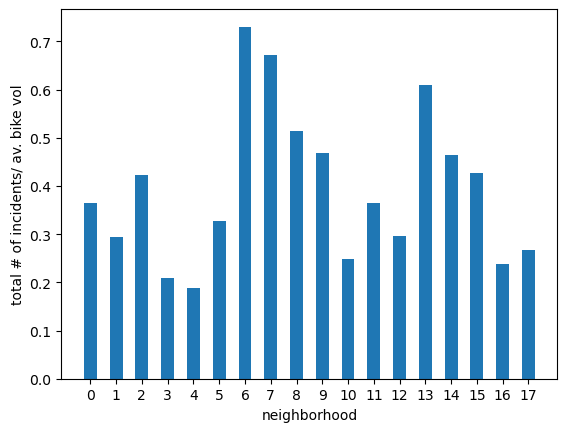

In [11]:
#plot total number of indicents normalized by bike volume

TInc_neigh_bikevol = TInc_neigh/TVol_neigh

plt.bar(np.arange(Nneigh).astype(int),TInc_neigh_bikevol,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('total # of incidents/ av. bike vol')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

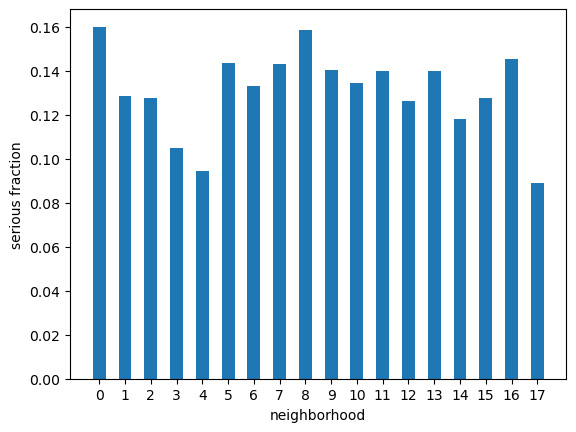

In [12]:
#plot frac. of serious accidents in each neighborhood

Tserious_neigh = np.zeros(Nneigh)
for ii in range(Nneigh):
    I = df_lond.neigh == ii
    Tserious_neigh[ii] = np.logical_not(df_lond.loc[I,'slight'].values).sum()
    
plt.bar(np.arange(Nneigh).astype(int),Tserious_neigh/TInc_neigh,width=0.5)
plt.xlabel('neighborhood')
plt.ylabel('serious fraction')
plt.xticks(np.arange(Nneigh).astype(int))
plt.show()

In [13]:
#idea, could maybe regress on the number of accidents particular roads have. Could form a list of 
#roads or sections within the dataset, maybe selecting those with enough data.
#Could even do this with neighborhoods, regress on total # of incidents that the neighborhood will have
#based on some features (like traffic volume) 

In [14]:
df_lond.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Vehicle_Type', 'Bicycles', 'fatal',
       'serious', 'slight', 'geometry', 'index_right', 'Road_name',
       'Road_name2', 'in_london', 'aadf_Count_point_id', 'aadf_Year',
       'aadf_Region_id', 'aadf_R

#### Make a DataFrame using df_lond that has entries only for traffic IDs. Main feature is # of incidents. 
- Other features are the aadf features that go along with the ID
- Also maybe some averaged features from accidents dataset (like junction control, maybe just use the classification with the most entries for that ID)
- Maybe the target variable should be number of incidents normalized by the bike volume (this is prob. of an incident)

##### Features to include
- all aadf features (do they neeed to be averaged over year? Maybe just average anyway)
- modes of classification features in accidents
- num. of incidents
- num. of serious and fatal incidents
- num. of indcidents normalized to bike volume from aadf

In [15]:
traf_IDs = np.array(df_lond.aadf_Count_point_id.value_counts().index)
Ninc_IDs = np.array(df_lond.aadf_Count_point_id.value_counts().values)

I = Ninc_IDs > 10
I.sum()

IDs_df = traf_IDs[I]
Nid = len(IDs_df)

df_road = pd.DataFrame({'aadfID':IDs_df})
slight_rd = np.zeros(Nid).astype(int)
ser_rd = np.zeros(Nid).astype(int)
total_rd = np.zeros(Nid).astype(int)
for nn,ii in enumerate(IDs_df):
    I = df_lond.aadf_Count_point_id.values == ii
    total_rd[nn] = I.sum()
    slight_rd[nn] = df_lond.loc[I,'slight'].values.sum()
    ser_rd[nn] = total_rd[nn] - slight_rd[nn]
df_road['total'] = total_rd
df_road['slight'] = slight_rd
df_road['serious'] = ser_rd

safety_mode = ['neigh','Road_name','Road_name2','h','Day_of_Week','m','Speed_limit','Junction_Detail','Junction_Control','Pedestrian_Crossing-Physical_Facilities']
aadf_av = ['aadf_Pedal_cycles','aadf_Pedal_cycles','aadf_All_motor_vehicles','aadf_All_HGVs','aadf_LGVs','aadf_Buses_and_coaches']
aadf_mode = ['aadf_Road_name','aadf_Road_category','aadf_Road_type']
for f in safety_mode:
    df_road[f] = np.zeros(Nid).astype(int)
    for nn,ii in enumerate(IDs_df):
        I = df_lond.aadf_Count_point_id.values == ii
        df_road.loc[nn,f] = df_lond.loc[I,f].mode().values[0]

for f in aadf_mode:
    df_road[f] = np.zeros(Nid).astype(int)
    for nn,ii in enumerate(IDs_df):
        I = df_lond.aadf_Count_point_id.values == ii
        df_road.loc[nn,f] = df_lond.loc[I,f].mode().values[0]
        
for f in aadf_av:
    df_road[f] = np.zeros(Nid).astype(int)
    for nn,ii in enumerate(IDs_df):
        I = df_lond.aadf_Count_point_id.values == ii
        df_road.loc[nn,f] = df_lond.loc[I,f].mean()
        
df_road['total_norm'] = df_road['total'].values/df_road['aadf_Pedal_cycles'].values
df_road['serious_ratio'] = df_road['serious'].values/df_road['total'].values

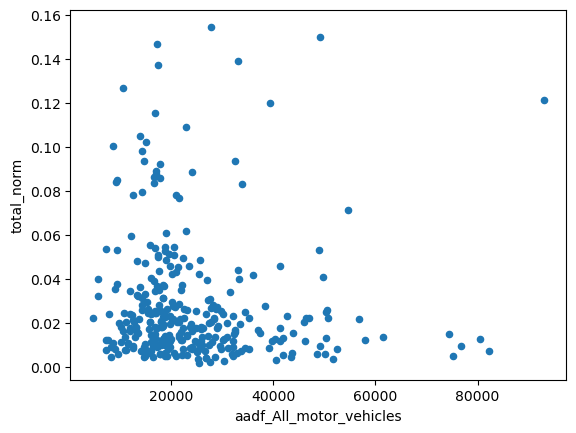

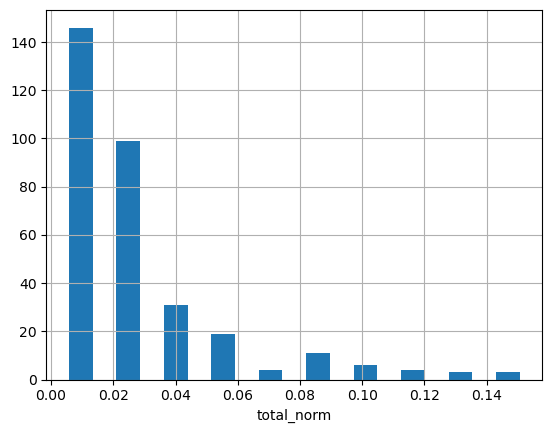

In [16]:
#make a scatter plot with total_norm and traffic volume

df_road.plot.scatter('aadf_All_motor_vehicles','total_norm')
plt.show()

df_road.total_norm.hist(rwidth=0.5)
plt.xlabel('total_norm')
plt.show()

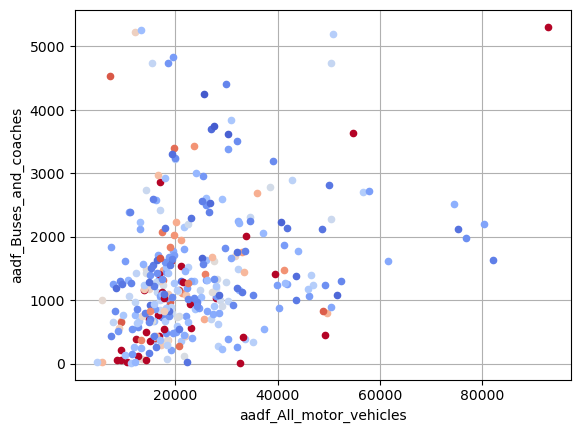

In [17]:
from matplotlib.cm import get_cmap
CMAP = get_cmap('coolwarm')

fig,ax = plt.subplots()

Nmap = 256
CLRs = CMAP(np.arange(Nmap))

xf = 'aadf_All_motor_vehicles'
yf = 'aadf_Buses_and_coaches'
#yf = 'aadf_All_HGVs'

vmin = 0.0
vmax = 0.06
vs = np.linspace(vmin,vmax,Nmap)
for ii in range(Nid):
    v = df_road.loc[ii,'total_norm']
    ic = np.argmin(np.abs(v-vs))
    ax.plot(df_road.loc[ii,xf],df_road.loc[ii,yf],
            marker='.',color = CLRs[ic],markersize=9)
    
ax.set_xlabel(xf)
ax.set_ylabel(yf)
#ax.set_yticks(np.arange(Nneigh))
ax.grid('on')
plt.show()

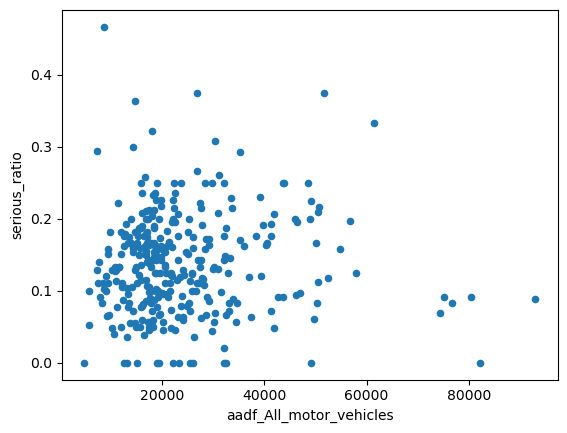

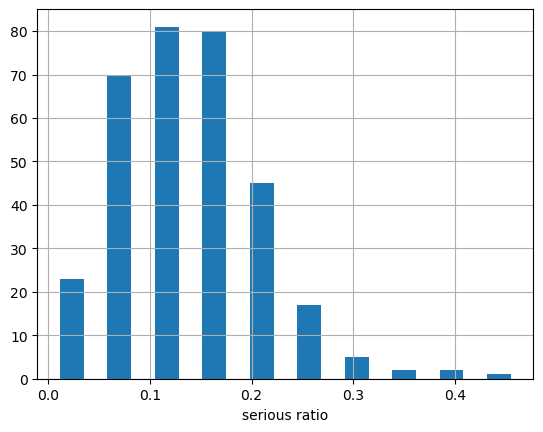

In [19]:
#make a scatter plot with total_norm and traffic volume

df_road.plot.scatter('aadf_All_motor_vehicles','serious_ratio')
plt.show()

df_road.serious_ratio.hist(rwidth=0.5)
plt.xlabel('serious ratio')
plt.show()

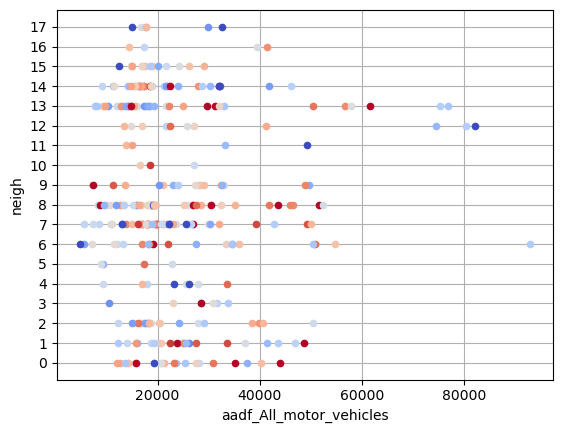

In [20]:
from matplotlib.cm import get_cmap
CMAP = get_cmap('coolwarm')

fig,ax = plt.subplots()

Nmap = 256
CLRs = CMAP(np.arange(Nmap))

xf = 'aadf_All_motor_vehicles'
yf = 'neigh'
#yf = 'aadf_All_HGVs'

vmin = 0.0
vmax = 0.25
vs = np.linspace(vmin,vmax,Nmap)
for ii in range(Nid):
    v = df_road.loc[ii,'serious_ratio']
    ic = np.argmin(np.abs(v-vs))
    ax.plot(df_road.loc[ii,xf],df_road.loc[ii,yf],
            marker='.',color = CLRs[ic],markersize=9)
    
ax.set_xlabel(xf)
ax.set_ylabel(yf)
ax.set_yticks(np.arange(Nneigh))
ax.grid('on')
plt.show()

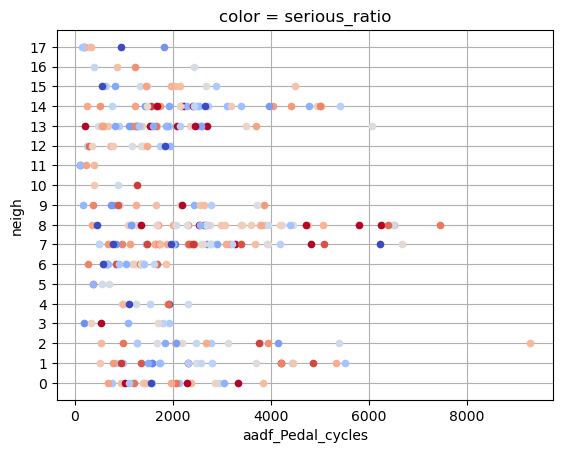

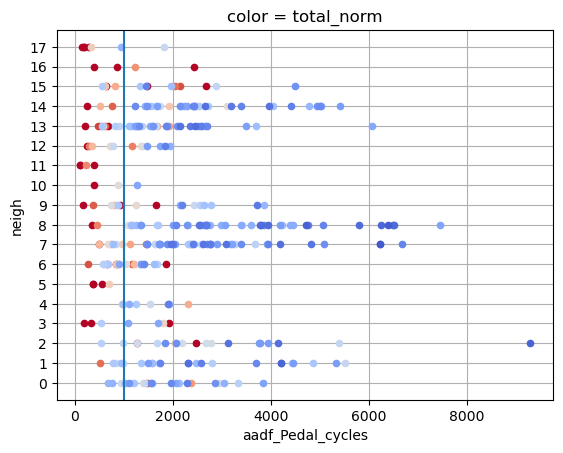

In [21]:
from matplotlib.cm import get_cmap
CMAP = get_cmap('coolwarm')

fig,ax = plt.subplots()

Nmap = 256
CLRs = CMAP(np.arange(Nmap))

xf = 'aadf_Pedal_cycles'
yf = 'neigh'
#yf = 'aadf_All_HGVs'

vmin = 0.0
vmax = 0.25
vs = np.linspace(vmin,vmax,Nmap)
for ii in range(Nid):
    v = df_road.loc[ii,'serious_ratio']
    ic = np.argmin(np.abs(v-vs))
    ax.plot(df_road.loc[ii,xf],df_road.loc[ii,yf],
            marker='.',color = CLRs[ic],markersize=9)
    
ax.set_xlabel(xf)
ax.set_ylabel(yf)
ax.set_yticks(np.arange(Nneigh))
ax.set_title('color = serious_ratio')
ax.grid('on')
plt.show()


fig,ax = plt.subplots()

xf = 'aadf_Pedal_cycles'
yf = 'neigh'
#yf = 'aadf_All_HGVs'

vmin = 0.0
vmax = 0.06
vs = np.linspace(vmin,vmax,Nmap)
for ii in range(Nid):
    v = df_road.loc[ii,'total_norm']
    ic = np.argmin(np.abs(v-vs))
    ax.plot(df_road.loc[ii,xf],df_road.loc[ii,yf],
            marker='.',color = CLRs[ic],markersize=9)
    
ax.set_xlabel(xf)
ax.set_ylabel(yf)
ax.set_yticks(np.arange(Nneigh))
ax.set_title('color = total_norm')
ax.grid('on')
ax.axvline(1000,0,1)
plt.show()

##### Maybe above plot suggests normalization does not work well for pedal cycles < 1000 or so

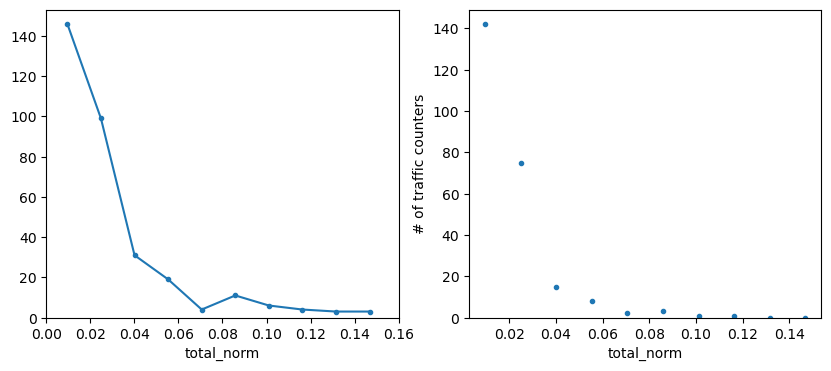

In [26]:
pedal_min = 1000
I = df_road.aadf_Pedal_cycles > pedal_min

fig,ax = plt.subplots(1,2,figsize=(2*5,4))

#edges,bins = make_bins()

ii = 0
H,edges = np.histogram(df_road.total_norm.values,bins=10)
db = np.diff(edges)[0]
#edges = np.append(bins-0.5*db,bins[-1]+0.5*db)
bins = edges[:-1]+0.5*db
ax[ii].plot(bins,H,marker='.')
ax[ii].set_xlabel('total_norm')
ax[ii].set_xlim(0,0.16)
ax[ii].set_ylim(0)

ii = 1
Hnorm,_ = np.histogram(df_road.loc[I,'total_norm'].values,bins=edges)

from scipy.special import factorial
from scipy.optimize import curve_fit

def poiss_eq(k,A,lam):
    return A*(lam**k)*np.exp(-k)/factorial(k)

bins_int = np.round(bins/bins.min())
#lam_r = [1e-40,0.01]
lam_r = [0.001,10]
A_r = [50,300]
coeff,_ = curve_fit(poiss_eq,bins_int,Hnorm,bounds=[[A_r[0],lam_r[0]],[A_r[1],lam_r[1]]])

ax[ii].plot(bins,Hnorm,marker='.',linestyle='none')
#ax[ii].plot(bins_int,poiss_eq(bins_int,*coeff))
ax[ii].set_xlabel('total_norm')
#ax[ii].set_xlim(0,0.16)
ax[ii].set_ylim(0)
#ax[ii].set_title(coeff)
ax[ii].set_ylabel('# of traffic counters')
plt.show()

In [94]:
mean = np.sum(bins_int*Hnorm)/Hnorm.sum()

var = np.sum( Hnorm*(bins_int-mean)**2)/len(bins)
print(var,mean)

77.48016194331984 2.182186234817814


#### Make a feature with bus volume / all motor volume. 

#### Plot the av. serious and av. total norm distribtions for neighborhoods within this dataset

#### Measure if road has increasing bike accidents of not (take derivative of Naccidents vs. year)

#### Maybe also look at total # of accidents logged vs. year (are there reporting differences?)

In [36]:
from scipy.special import factorial
from scipy.optimize import curve_fit

def poiss_eq(k,A,lam):
    return A*(lam**k)*np.exp(-k)/factorial(k)

lam_r = [1e-5,0.02]
A_r = [50,300]
Y = 

0.9999422883231621